#MLP with Sigmoid and MSE

##Imports

In [111]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
%matplotlib inline


In [112]:
import time
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch

##Settings and Device

In [113]:
randomSeed = 1
numEpochs = 100
batchSize = 100

In [114]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [115]:
trainData = datasets.MNIST(root='data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

testData = datasets.MNIST(root='data',
                          train=False,
                          transform = transforms.ToTensor())

trainLoader = DataLoader(dataset = trainData, batch_size = batchSize, shuffle=True)
testLoader  = DataLoader(dataset = testData , batch_size = batchSize, shuffle=True)

In [116]:
for images,labels in trainLoader:
  print('Image batch dimensions: ', images.shape)
  print('Label batch dimensions: ', labels.shape)
  break

Image batch dimensions:  torch.Size([100, 1, 28, 28])
Label batch dimensions:  torch.Size([100])


##One Hot Encoding

In [117]:
def toOneHot(y,nClasses):
  yOneHot = torch.FloatTensor(y.size(0),nClasses)
  yOneHot.zero_()
  tmp = y.view(-1,1).long().to(torch.device("cpu"))
  yOneHot.scatter_(1,tmp,1).float()
  return yOneHot


##Model

In [118]:
class MLP_SigmoidMSE(torch.nn.Module):
  def __init__(self,numFeatures,numHidden,numClasses):
    super(MLP_SigmoidMSE,self).__init__()
    self.numClasses = numClasses

    self.linearLayer = torch.nn.Linear(numFeatures,numHidden)
    self.linearLayer.weight.detach().normal_(0.0,0.1)
    self.linearLayer.bias.detach().zero_()

    self.linearOut = torch.nn.Linear(numHidden,numClasses)
    self.linearOut.weight.detach().normal_(0,0.1)
    self.linearOut.bias.detach().zero_()

  def forward(self,x):
    out = self.linearLayer(x)
    out = torch.sigmoid(out)
    logits = self.linearOut(out)
    proba = torch.sigmoid(logits)
    return logits,proba



In [119]:
torch.manual_seed(randomSeed)
model = MLP_SigmoidMSE(numFeatures=28*28,numHidden=100,numClasses=10)
model = model.to(DEVICE)


In [120]:
optimizer = torch.optim.SGD(model.parameters(),lr=0.1)

In [121]:
def computeMSE(M,dataLoader):
  currMSE,numExamples = torch.zeros(M.numClasses).float().to(DEVICE) , 0
  with torch.no_grad():
    for features,targets in dataLoader:
      features = features.view(-1,28*28).to(DEVICE)
      # print(1)
      # print(features.get_device())
      # print(M.get_device())
      logits,probas = M.forward(features)
      # print(2)
      yOneHot = toOneHot(targets,model.numClasses).to(DEVICE)
      # print(3)
      loss = torch.sum((yOneHot - probas)**2, dim=0)
      # print(4)
      numExamples+=targets.size(0)
      # print(5)
      currMSE+=loss
      # print(6)
    currMSE = torch.mean(currMSE/numExamples, dim=0)
    # print(7)
    return currMSE

##Training

In [122]:
startTime = time.time()
miniBatchCost = []
epochCost = []
# rmpty = torch.empty()
for epoch in range(numEpochs):
  model.train()
  for batchIDx, (features,targets) in enumerate(trainLoader):
    # features = features.view(-1,784).to(DEVICE)
    # # rmpty.append(features)
    # logits,probas = model(features)

    # yOneHoted = toOneHot(targets,model.numClasses).to(DEVICE)

    # cost = F.mse_loss(yOneHoted,probas)
    # optimizer.zero_grad()

    # cost.backward()
    # miniBatchCost.append(cost.item())

    # optimizer.step()
    features = features.view(-1, 28*28).to(DEVICE)

        ### FORWARD AND BACK PROP
    logits, probas = model(features)

    y_onehot = toOneHot(targets, model.numClasses).to(DEVICE)

    cost = F.mse_loss(y_onehot, probas)
    optimizer.zero_grad()

    cost.backward()
    miniBatchCost.append(cost.item())
    ### UPDATE MODEL PARAMETERS
    optimizer.step()

    if(not batchIDx % 50):
      print("Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f" %(epoch+1,numEpochs,batchIDx,len(trainLoader),cost.item()))
      # print(features)
  print("Cost")
  currCost = computeMSE(model,trainLoader)
  epochCost.append(currCost.item())
  print("Epoch: %03d/%03d | Cost: %.4f" %(epoch+1,numEpochs,currCost))
  print("Time Elasped: %.2f min" % ((time.time() - startTime)/60))

print("Total Time Elasped: %.2f min" % ((time.time() - startTime)/60))



Epoch: 001/100 | Batch 000/600 | Cost: 0.2551
Epoch: 001/100 | Batch 050/600 | Cost: 0.1029
Epoch: 001/100 | Batch 100/600 | Cost: 0.0935
Epoch: 001/100 | Batch 150/600 | Cost: 0.0908
Epoch: 001/100 | Batch 200/600 | Cost: 0.0897
Epoch: 001/100 | Batch 250/600 | Cost: 0.0900
Epoch: 001/100 | Batch 300/600 | Cost: 0.0896
Epoch: 001/100 | Batch 350/600 | Cost: 0.0888
Epoch: 001/100 | Batch 400/600 | Cost: 0.0892
Epoch: 001/100 | Batch 450/600 | Cost: 0.0886
Epoch: 001/100 | Batch 500/600 | Cost: 0.0887
Epoch: 001/100 | Batch 550/600 | Cost: 0.0883
Cost
Epoch: 001/100 | Cost: 0.0881
Time Elasped: 0.30 min
Epoch: 002/100 | Batch 000/600 | Cost: 0.0877
Epoch: 002/100 | Batch 050/600 | Cost: 0.0875
Epoch: 002/100 | Batch 100/600 | Cost: 0.0885
Epoch: 002/100 | Batch 150/600 | Cost: 0.0875
Epoch: 002/100 | Batch 200/600 | Cost: 0.0869
Epoch: 002/100 | Batch 250/600 | Cost: 0.0871
Epoch: 002/100 | Batch 300/600 | Cost: 0.0860
Epoch: 002/100 | Batch 350/600 | Cost: 0.0866
Epoch: 002/100 | Batch

##Model Evaluation

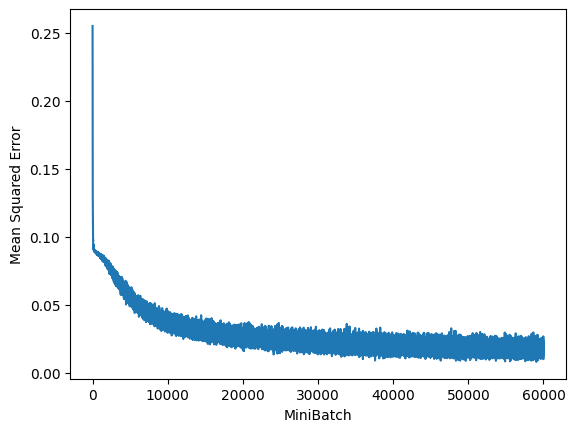

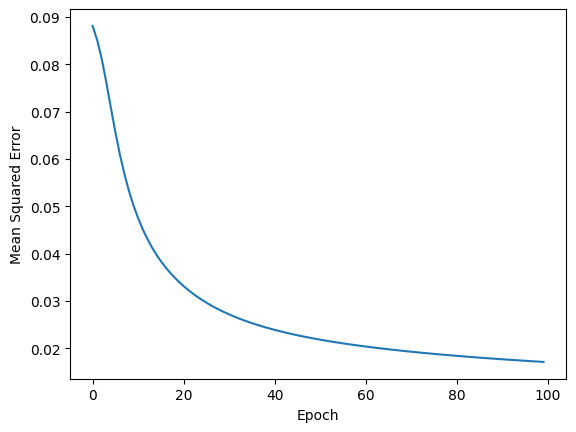

In [123]:
plt.plot(range(len(miniBatchCost)),miniBatchCost)
plt.ylabel("Mean Squared Error")
plt.xlabel("MiniBatch")
plt.show()

plt.plot(range(len(epochCost)),epochCost)
plt.ylabel("Mean Squared Error")
plt.xlabel("Epoch")
plt.show()

In [124]:
def computeAcc(net,dataLoader):
  correctPred,numExamples = 0 , 0
  with torch.no_grad():
    for features,targets in dataLoader:
      features = features.view(-1,28*28)
      logits,probas = net.forward(features)
      pred = torch.argmax(probas,1)
      numExamples+=targets.size(0)
      correctPred+=(pred==targets).sum()
      # yOneHot = toOneHot(targets,model.numClasses)
      # loss = torch.sum((yOneHot - probas)**2, dim=0)
      # numExamples+=targets.size(0)
      # currMSE+=loss
    # currMSE = torch.mean(currMSE/numExamples, dim=0)
    return correctPred.float()/numExamples * 100


In [125]:
print("Training Accuracy :%.2f%%" % (computeAcc(model,trainLoader)))
print("Testing  Accuracy :%.2f%%" % (computeAcc(model,testLoader )))


Training Accuracy :90.78%
Testing  Accuracy :91.33%
